# QUE 01: Image Display

Text(0.5, 1.0, 'actual image')

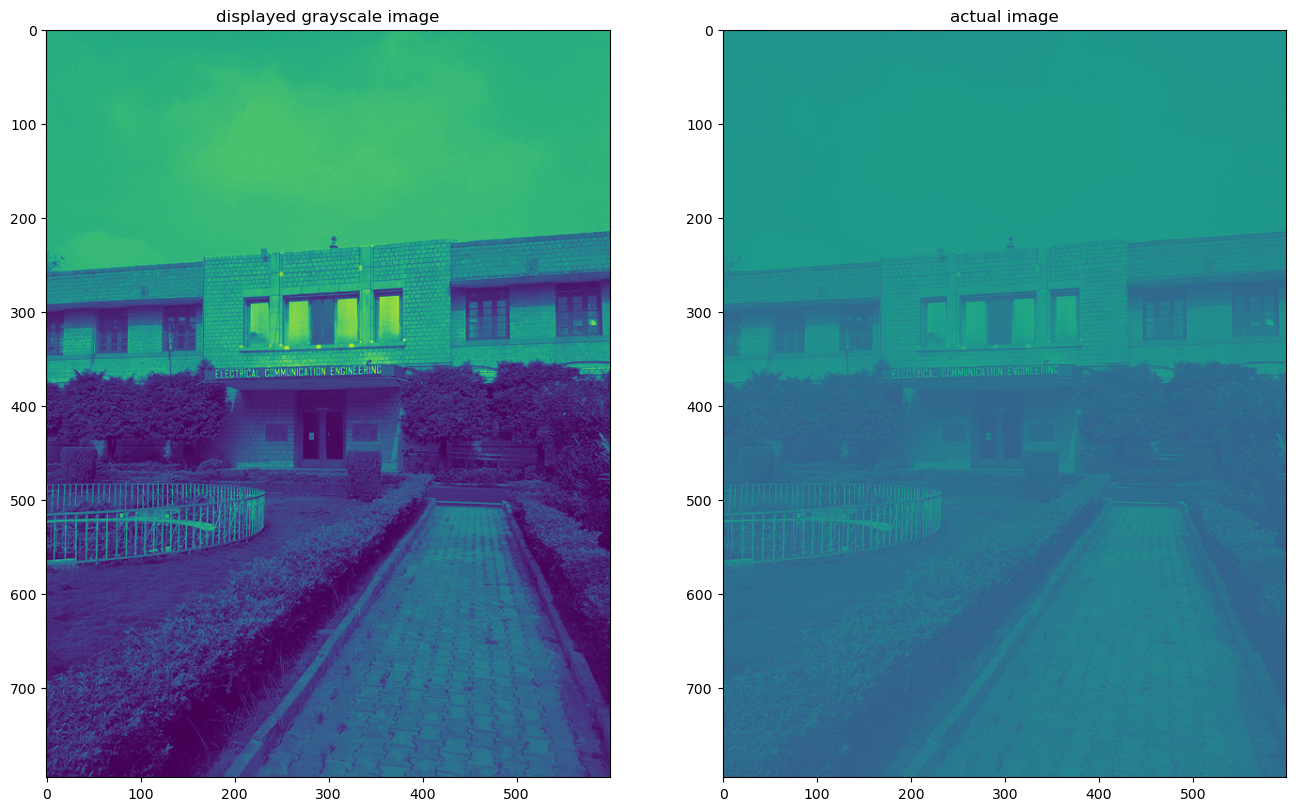

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"]=[16,10]
from skimage.io import imread
plt.subplot(1,2,1)
im = imread('ECE.png')
a=plt.imshow(im)
plt.title('displayed grayscale image')

plt.subplot(1,2,2)
b=plt.imshow(im,vmin=0,vmax=255,interpolation='nearest')
plt.title('actual image')

In [2]:
I=np.array(b)

# QUE 02: Contrast Stretching

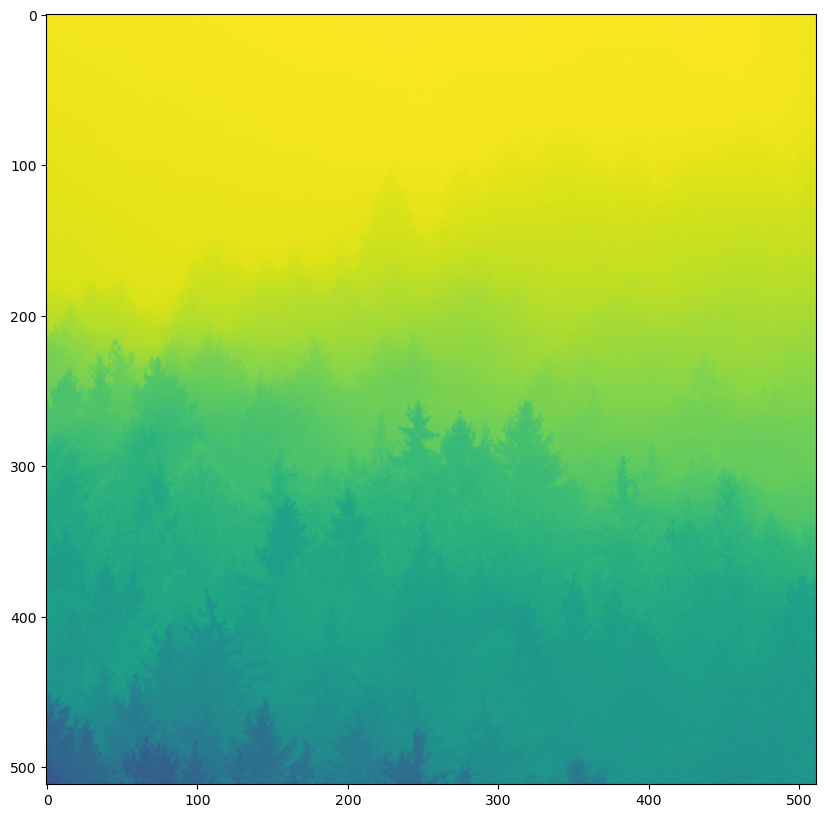

In [3]:
hazy_image=imread('hazy.png')
plt.imshow(hazy_image,vmin=0,vmax=255,interpolation='nearest')

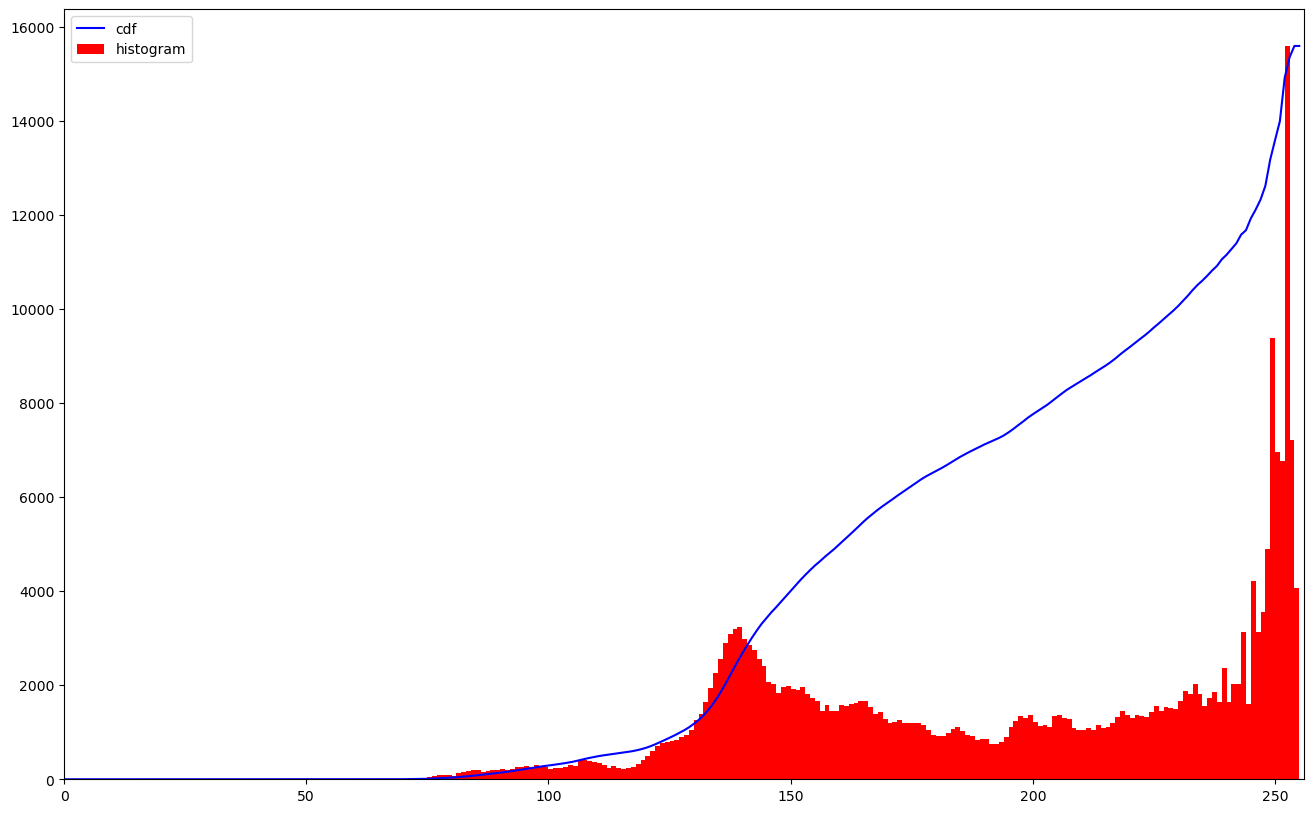

In [4]:
hist,bins = np.histogram(hazy_image.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(hazy_image.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [5]:
def histogram_equalization(image):
    img_array=np.array(image)
    histogram_array = np.bincount(img_array.flatten(), minlength=256)
    num_pixels = np.sum(histogram_array)
    histogram_array = histogram_array/num_pixels
    chistogram_array = np.cumsum(histogram_array)
    transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
    img_list = list(img_array.flatten())
    eq_img_list = [transform_map[p] for p in img_list]
    eq_img_array = np.reshape(np.asarray(eq_img_list), img_array.shape)
    return eq_img_array

def gamma_transform(image,gamma):
    gamma_image=np.array(255*(image/255)**gamma,dtype='uint8')
    return gamma_image
    
    
    

In [6]:
equalized_image=histogram_equalization(hazy_image)

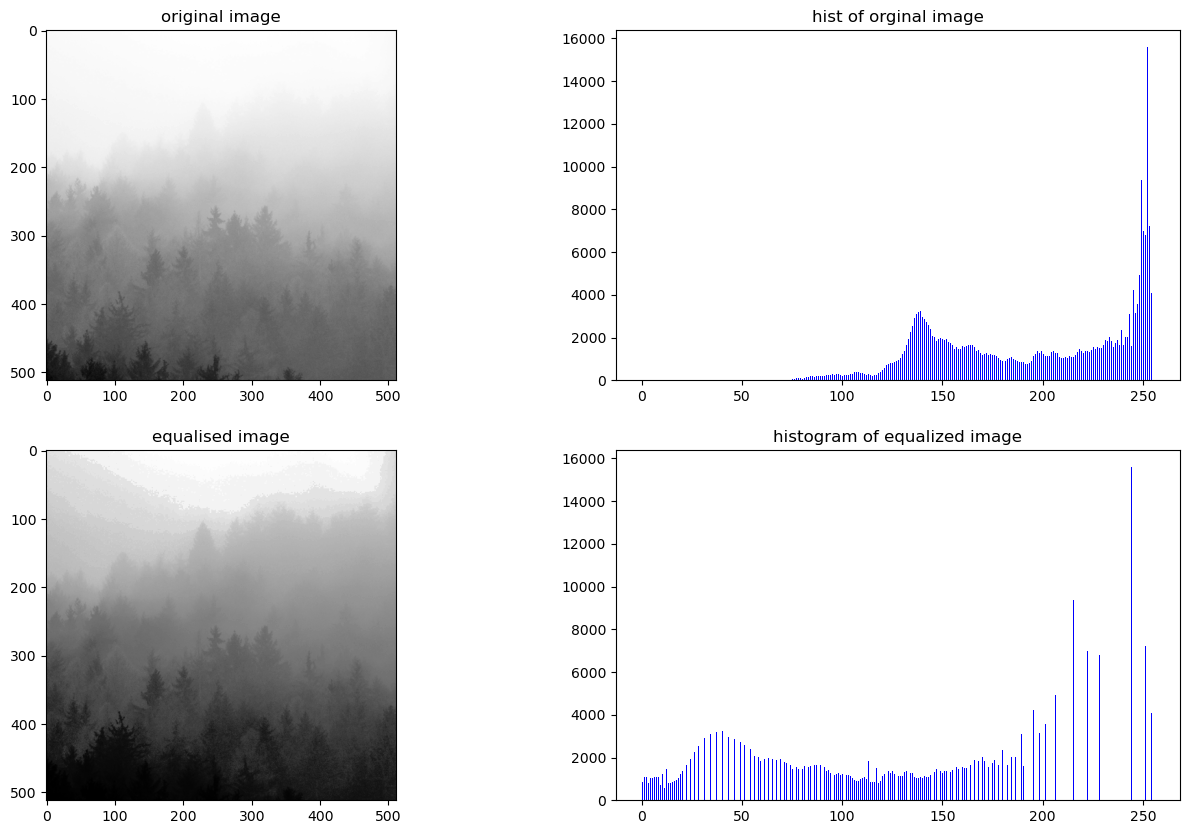

In [7]:
hist_haze,bins_haze=np.histogram(hazy_image,bins=256,range=[0,256])
hist_equalized,bins_equalized=np.histogram(equalized_image,bins=256,range=[0,256])
plt.subplot(2,2,1)
plt.title("original image")
plt.imshow(hazy_image,cmap='gray')

plt.subplot(2,2,2)
plt.title('hist of orginal image')
plt.bar(range(256), hist_haze, width=0.5, align='edge',color='b')

plt.subplot(2,2,3)
plt.title('equalised image')
plt.imshow(equalized_image,cmap='gray')

plt.subplot(2,2,4)
plt.title('histogram of equalized image')
plt.bar(range(256), hist_equalized, width=0.5, align='edge',color='b')
plt.show()

In [8]:
gamma_=np.arange(0,5,0.005)
mse_ls=[]
for gamma in gamma_:
    mse=((gamma_transform(hazy_image,gamma)/100 -equalized_image/100)**2).mean(axis=None)
    mse_ls.append(mse)
    
gamma_min=gamma_[np.argmin(mse_ls)]
print(gamma_min)
    

2.955


In [9]:
print(f"optimal gamma:{gamma_min}")

optimal gamma:2.955


In [10]:
gamma_transformed_image=gamma_transform(hazy_image,gamma_min)

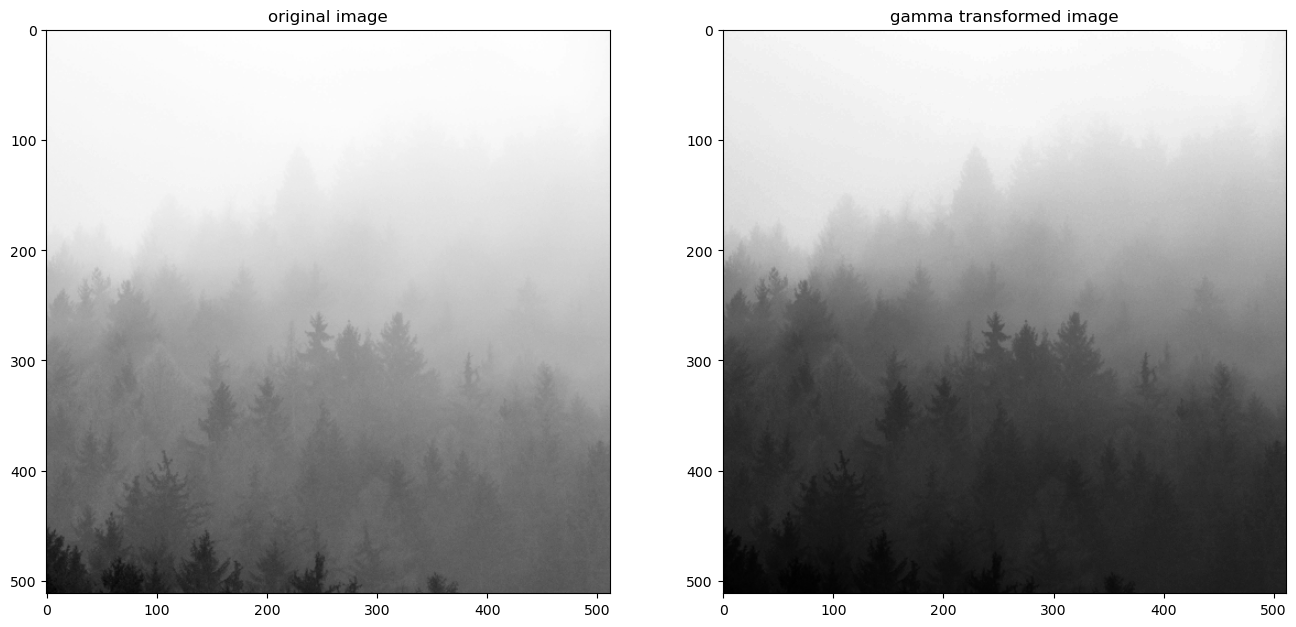

In [11]:
plt.subplot(1,2,1)
plt.title('original image')
plt.imshow(hazy_image,cmap='gray')
plt.subplot(1,2,2)
plt.title('gamma transformed image')
plt.imshow(gamma_transformed_image,cmap='gray')
plt.show()

# QUE 03: Image Rotation

In [12]:
from PIL import Image, ImageTk
import math
import tkinter as tk

In [13]:

def rotation(image,angle,interpolation="nearest_neighbour"):
    if image.mode != "RGB":
        raise ValueError("Image mode must be RGB")
    
     
        
    angle_radians=math.radians(angle)
    width,height=image.size
    new_width=int(abs(width*math.cos(angle_radians))+abs(height*math.sin(angle_radians)))
    new_height=int(abs(width*math.sin(angle_radians))+abs(height*math.cos(angle_radians)))
    rotated_image=Image.new("RGB",(new_width,new_height),(255,255,255))
    centre_x=(new_width)//2
    centre_y=(new_height)//2
    x_offset = (new_width - width) // 2
    y_offset = (new_height - height) // 2
    
    
    
    rot_matrix=[math.cos(angle_radians),-math.sin(angle_radians),math.sin(angle_radians),math.cos(angle_radians)]
    inv_rot_matrix=[math.cos(-angle_radians),-math.sin(-angle_radians),math.sin(-angle_radians),math.cos(-angle_radians)]
    
    if interpolation=="nearest_neighbor":
        interpolate=lambda x,y:nearest_neighbor(image,x,y,inv_rot_matrix,width,height)
    elif interpolation=="bilinear":
        interpolate=lambda x,y:bilinear(image,x,y,inv_rot_matrix,width,height)
    else:
        raise ValueError("Interpolation must be either nearest neighbour or bilinear")
        
    
    rotated_image.paste(image.rotate(angle, resample=Image.BILINEAR), (x_offset, y_offset))            
    return rotated_image            
    

In [14]:
def apply_matrix(matrix,x,y,centre_x,centre_y):
    new_x=matrix[0]*(x-centre_x)+matrix[1]*(y-centre_y)+centre_x
    new_y=matrix[2]*(x-centre_x)+matrix[3]*(y-centre_y)+centre_x
    return new_x,new_y

In [15]:
def nearest_neighbor(image, x, y, inv_rot_matrix, width, height):
    src_x, src_y = apply_matrix(inv_rot_matrix, x, y, width / 2, height / 2)
    src_x = int(src_x)
    src_y = int(src_y)
    if 0 <= src_x < width and 0 <= src_y < height:
        return image.getpixel((src_x, src_y))
    else:
        return (255, 255, 255)  

In [16]:
def lerp(a, b, t):
    
    return tuple(int((1 - t) * x1 + t * x2) for x1, x2 in zip(a, b))

In [17]:
def bilinear(image, x, y,inv_rot_matrix, width, height):
    x1, y1 = int(math.floor(x)), int(math.floor(y))
    x2, y2 = int(math.ceil(x)), int(math.ceil(y))

    if (
        0 <= x1 < width and 0 <= x2 < width and
        0 <= y1 < height and 0 <= y2 < height
    ):
        q1 = image.getpixel((x1, y1))
        q2 = image.getpixel((x2, y1))
        q3 = image.getpixel((x1, y2))
        q4 = image.getpixel((x2, y2))

        dx = x - x1
        dy = y - y1

        r1 = lerp(q1, q2, dx)
        r2 = lerp(q3, q4, dx)
        return lerp(r1, r2, dy)

    else:
        return (255, 255, 255)

In [18]:

if __name__ == "__main__":
    image=Image.open('box.png').convert('RGB')
    
    

    # Rotate 'box.png' by 5 degrees clockwise using bilinear interpolation
    rotated_img_bilinear_5 = rotation(image, 5, interpolation="bilinear")
    rotated_img_bilinear_5.save('box_rotated_bilinear_5.png')
    
    rotated_img_nn_5 = rotation(image, 5, interpolation="nearest_neighbor")
    rotated_img_nn_5.save('box_rotated_nn_5.png')
    
    

    # Rotate 'box.png' by 30 degrees counter-clockwise using nearest neighbor interpolation
    rotated_img_nn_30 = rotation(image, -30, interpolation="nearest_neighbor")
    rotated_img_nn_30.save('box_rotated_nn_30.png')
   

    # Rotate 'box.png' by 30 degrees counter-clockwise using bilinear interpolation
    rotated_img_bilinear_30 = rotation(image, -30, interpolation="bilinear")
    rotated_img_bilinear_30.save('box_rotated_bilinear_30.png')
       

C:\Users\Gaurav Talekar\AppData\Local\Temp\ipykernel_13924\2800890045.py:30: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  rotated_image.paste(image.rotate(angle, resample=Image.BILINEAR), (x_offset, y_offset))


# QUE 04:Spatial Filtering

In [21]:
import numpy as np
from PIL import Image

image = Image.open('study.png').convert('L')

image_array = np.array(image, dtype=float)

kernel = np.ones((5, 5)) / 25  

smoothed_image = np.zeros_like(image_array)
for x in range(2, image_array.shape[0] - 2):
    for y in range(2, image_array.shape[1] - 2):
        smoothed_image[x, y] = np.sum(image_array[x - 2:x + 3, y - 2:y + 3] * kernel)

high_pass = image_array - smoothed_image

k = 2.5
high_boost_filtered = image_array + k * high_pass

high_boost_filtered = np.clip(high_boost_filtered, 0, 255)



sharpened_image = Image.fromarray(np.uint8(high_boost_filtered))

image.show(title='Original Grayscale Image')
sharpened_image.show(title='Sharpened Grayscale Image')


sharpened_image.save('sharpened_study.png')

